<a href="https://colab.research.google.com/github/myidispg/PytorchProjects/blob/master/Private%20AI/differential_privacy_deep_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import torch
import torchvision

import numpy as np
import matplotlib.pyplot as plt


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

## Differentially private Gradient Descent Optimizer


In [0]:
import math
import uuid
from torch.optim.optimizer import Optimizer, required

import torch.nn.functional as F

PI =  torch.cuda.FloatTensor([math.pi])
NORM = (torch.sqrt(2.0*PI))

def norm(x, mean, std_dev):
  y = (x-mean)/std_dev
  return (torch.exp((-y).pow(2)/2.0)/NORM)/std_dev

class DPSGD(Optimizer):
  
  def __init__(self, params, lr=required, momentum=0, dampening=0,
               weight_decay=0, nesterov=False, C=1, noise_multiplier=1.0,
               batch_size=256):
    
    # This section is same as the official SGD implementation
    if lr is not required and lr < 0.0:
      raise ValueError("Invalid learning rate: {}".format(lr))
    if momentum < 0.0:
      raise ValueError("Invalid momentum value: {}".format(momentum))
    if weight_decay < 0.0:
      raise ValueError("Invalid weight_decay value: {}".format(weight_decay))

    defaults = dict(lr=lr, momentum=momentum, dampening=dampening,
                    weight_decay=weight_decay, nesterov=nesterov)
    if nesterov and (momentum <= 0 or dampening != 0):
      raise ValueError("Nesterov momentum requires a momentum and zero dampening")
    super(DPSGD, self).__init__(params, defaults)
    # -----------------------------------------------------------

    self.batch_size = batch_size
    self.C = C
    self.noise_multiplier = noise_multiplier
  
  def __setstate__(self, state):
    super(SGD, self).__setstate__(state)
    for group in self.param_groups:
      group.setdefault('nesterov', False)
      
  def step(self, closure=None):
    """Performs a single optimization step.
    Arguments:
        closure (callable, optional): A closure that reevaluates the model
            and returns the loss.
    """
    self.noise_std_dev = self.noise_multiplier * self.C
    
    loss = None
    
    if closure is not None:
      loss = closure()
      
    # Accumulate the norm of all the grads
    norm = 0
    
    for group in self.param_groups:
      for p in group['params']:
        if p.grad is None:
          continue
        grad = p.grad.data
        
        norm += grad.norm()**2.0
        
        
    norm  = norm ** 0.5
    
    # Perform gradient clipping
    for group in self.param_groups:
      for p in group['params']:
        grad = p.grad.data
        
        clipped_grads = grad/torch.max(norm/self.C, torch.ones_like(norm))
        
        p.grad.data = clipped_grads
    
    # Add noise to the clipped gradients
    for group in self.param_groups:
      for p in group['params']:
        
        noise = torch.zeros_like(p)
        noise.normal_(mean=0, std = self.noise_std_dev)
#         noise = torch.from_numpy(np.random.laplace(0, beta, p.shape)).float().to(device)
        p.grad.data += self.noise_multiplier * noise
    
    for group in self.param_groups:
      weight_decay = group['weight_decay']
      momentum = group['momentum']
      dampening = group['dampening']
      nesterov = group['nesterov']

      for p in group['params']:
        if p.grad is None:
          continue
        d_p = p.grad.data
        if weight_decay != 0:
          d_p.add_(weight_decay, p.data)
        if momentum != 0:
          param_state = self.state[p]
          if 'momentum_buffer' not in param_state:
            buf = param_state['momentum_buffer'] = torch.clone(d_p).detach()
          else:
            buf = param_state['momentum_buffer']
            buf.mul_(momentum).add_(1 - dampening, d_p)
          if nesterov:
            d_p = d_p.add(momentum, buf)
          else:
            d_p = buf
            
            
        p.data.add_(-group['lr'], d_p)

        return loss


## Load the MNIST Dataset using Torchvision

In [8]:
transforms = torchvision.transforms.Compose([torchvision.transforms.ToTensor(),
                                             torchvision.transforms.Normalize((0.5,), (0.5,))])

mnist_trainset = torchvision.datasets.MNIST(root='./MNIST_data/', train=True, download=True, transform=transforms)
mnist_testset = torchvision.datasets.MNIST(root='./MNIST_data/', train=False, download=True, transform=transforms)
print(f'Trainset length: {len(mnist_trainset)}')
print(f'Testset: {len(mnist_testset)}')
trainloader = torch.utils.data.DataLoader(mnist_trainset, batch_size=64, shuffle=True)
testloader = torch.utils.data.DataLoader(mnist_testset, batch_size=64, shuffle=True)

classes = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

Trainset length: 60000
Testset: 10000


Plotting 10 random images from the train set and their corresponding labels...


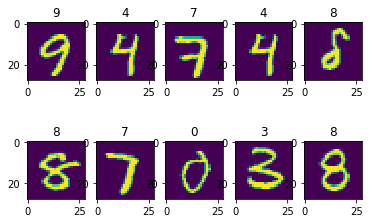

In [9]:
# To unnormalize the image and put channel after the image height and width.
def im_show_process(img):
  img = (img / 2) + 0.5 # Unnormalize the image
  img = img.numpy()
  
  # Since, PyTorch needs channels before the height and width and
  # matplotlib needs channels afterwards, transpose them to make images compatible.
  return np.transpose(img, (1, 2, 0)).reshape(img.shape[1], -1)

print(f'Plotting 10 random images from the train set and their corresponding labels...')
dataiter = iter(trainloader)
images, labels = dataiter.next()

f, axarr = plt.subplots(2, 5)

for i in range(2):
  for j in range(5):
    index = np.random.randint(0, 64)
    image = im_show_process(images[index])
#     image = images[index]
    axarr[i, j].imshow(image)
    axarr[i, j].set_title(classes[labels[index]])

Plotting 10 random images from the test set and their corresponding labels...


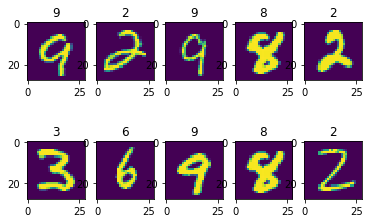

In [10]:
print(f'Plotting 10 random images from the test set and their corresponding labels...')
dataiter = iter(testloader)
images, labels = dataiter.next()

f, axarr = plt.subplots(2, 5)

for i in range(2):
  for j in range(5):
    index = np.random.randint(0, 64)
    axarr[i, j].imshow(im_show_process(images[index]))
    axarr[i, j].set_title(classes[labels[index]])

## Building the model

In [11]:
import torch.nn as nn
import torch.nn.functional as F

class Model(nn.Module):
  
  def __init__(self):
    super(Model, self).__init__()
    
    self.conv1 = nn.Conv2d(1, 16, kernel_size=(8,8), stride=2)
    self.pool1 = nn.MaxPool2d(kernel_size=(2,2), stride=1)
    self.conv2 = nn.Conv2d(16, 32, kernel_size=(4,4), stride=2)
    self.pool2 = nn.MaxPool2d(kernel_size=(2,2), stride=1)
    
    self.fc1 = nn.Linear(288, 128)
    self.fc2 = nn.Linear(128, 64)
    self.fc3 = nn.Linear(64, 10)
    
  def forward(self, X):
    
    # Convert to channels first format
    X = X.view(X.shape[0], 1, 28, 28)
    
    X = self.pool1(F.relu(self.conv1(X)))
    X = self.pool2(F.relu(self.conv2(X)))
    
    X = X.view(X.shape[0], -1)
#     print(X.shape)
    
    hidden = F.relu(self.fc1(X))
    hidden = F.relu(self.fc2(hidden))
    
    return self.fc3(hidden)
  
model = Model()
image = torch.randn((64, 28, 28, 1))
print(f"Image's shape before inputting: {image.shape}")
image = model(image)
print(f'Output image shape: {image.shape}')

Image's shape before inputting: torch.Size([64, 28, 28, 1])
Output image shape: torch.Size([64, 10])


##Defining some parameters and criterion, optimizer

In [0]:
epsilon = 3.01
beta = 1/epsilon
lr = 0.15
epochs = 150
train_loss = []
validation_loss = []
validation_acc = []

running_loss = 0

model = Model().to(device)
criterion = nn.CrossEntropyLoss()
# optimizer = torch.optim.SGD(model.parameters(), lr=lr)
optimizer = DPSGD(model.parameters(), lr=lr, C=4, noise_multiplier=0.1)

###Training the model

In [0]:
for epoch in range(epochs):

  for inputs, labels in trainloader:
    inputs, labels = inputs.to(device), labels.to(device)
    optimizer.zero_grad()

    logps = model(inputs)
    loss = criterion(logps, labels)
    loss.backward()

    # Perform gradient clipping in l2 norm
#     for params in model.parameters():
#       print(params.shape)
      
#     nn.utils.clip_grad_norm_(model.parameters(), 4)
    
#     for params in model.parameters():
#       noise = torch.from_numpy(np.random.laplace(0, beta, params.shape)).float().to(device)
#       params.grad += 1.1 * noise
    
    optimizer.step()
    running_loss += loss.item()
  
  else:
    test_loss = 0
    accuracy = 0
    model.eval()
    with torch.no_grad():
      for inputs, labels in testloader:
        inputs, labels = inputs.to(device), labels.to(device)
        logps = model(inputs)
        batch_loss = criterion(logps, labels)
        
        test_loss += batch_loss.item()
         
        # Calculate accuracy
        ps = torch.exp(logps)
        top_p, top_class = ps.topk(1, dim=1)
        equals = top_class == labels.view(*top_class.shape)
        accuracy += torch.mean(equals.type(torch.FloatTensor)).item()
          
      print(f"Epoch {epoch+1}/{epochs}.. "
            f"Train loss: {running_loss/len(trainloader):.8f}.. "
            f"Test loss: {test_loss/len(testloader):.8f}.. "
            f"Test accuracy: {accuracy/len(testloader):.8f}")
      train_loss.append(running_loss/len(trainloader))
      validation_loss.append(test_loss/len(testloader))
      validation_acc.append(accuracy/(len(testloader)))
      running_loss = 0
      model.train()


Epoch 1/150.. Train loss: 2.28299243.. Test loss: 2.25483374.. Test accuracy: 0.23089172
Epoch 2/150.. Train loss: 2.23332265.. Test loss: 2.21078662.. Test accuracy: 0.25437898
Epoch 3/150.. Train loss: 2.19103020.. Test loss: 2.17275444.. Test accuracy: 0.25019904
Epoch 4/150.. Train loss: 2.15408561.. Test loss: 2.13768285.. Test accuracy: 0.24810908
Epoch 5/150.. Train loss: 2.12055210.. Test loss: 2.10447360.. Test accuracy: 0.25189092
Epoch 6/150.. Train loss: 2.08668573.. Test loss: 2.07148413.. Test accuracy: 0.28921178
Epoch 7/150.. Train loss: 2.05800745.. Test loss: 2.04347800.. Test accuracy: 0.32195462
Epoch 8/150.. Train loss: 2.02824059.. Test loss: 2.01638429.. Test accuracy: 0.33976911
Epoch 9/150.. Train loss: 2.00866950.. Test loss: 1.99938598.. Test accuracy: 0.38067277
Epoch 10/150.. Train loss: 1.98894327.. Test loss: 1.97957861.. Test accuracy: 0.37957803
Epoch 11/150.. Train loss: 1.97074634.. Test loss: 1.96338227.. Test accuracy: 0.38345939
Epoch 12/150.. Trai

Text(0.5, 1.0, 'Training Losses')

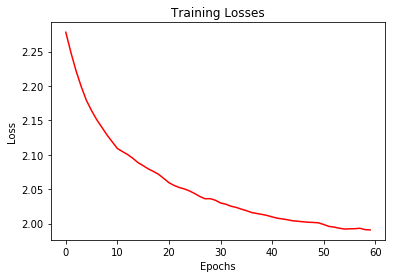

In [18]:
# Plot the training losses.
plt.plot(train_loss, color='r')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Losses')

Text(0.5, 1.0, 'Validation Losses')

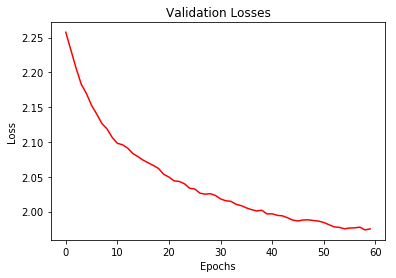

In [19]:
# Plot Validation losses

plt.plot(validation_loss, color='r')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Validation Losses')

Text(0.5, 1.0, 'Validation Accuracy')

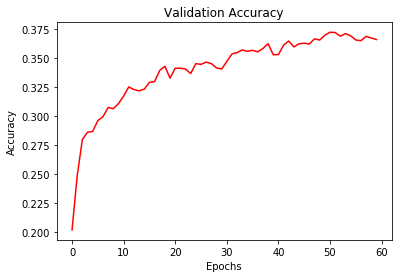

In [20]:
# Plot the validation accuracy
plt.plot(validation_acc, color='r')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Validation Accuracy')